In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import torchvision.models as models
from PIL import Image
from matplotlib import pyplot as plt
# %matplotlib widget
import numpy as np
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from ilt_data import PNGFolderDataset, tensor_to_image
from ilt_model import LithoZernikeRegressor
# torch.multiprocessing.set_start_method('spawn')# good solution !!!!

In [2]:
DATASET_ROOT = os.path.join('..', 'dataset', 'train_layouts')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.zeros((1,), device=device)

In [3]:
# -------- 3. DataLoader --------
def make_dataloaders(root, batch_size=16, num_zernike=20, split=0.8, workers=1):
    dataset = PNGFolderDataset(root, N_zernike=num_zernike, image_size=512, aberr_max=3.)
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    return train_loader, val_loader, dataset

Aberrations: Z=[ 2.672827  -0.80582   -2.551587  -1.4826332 -0.700878   0.6053245]


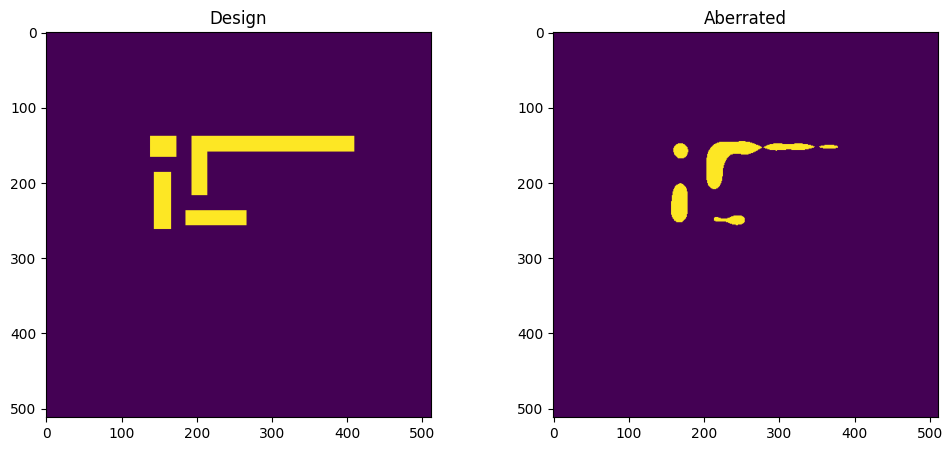

In [4]:
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=1, num_zernike=6, workers=0)
a = next(iter(train_loader))
i = 0

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][0]))
ax.set_title("Design")
ax = plt.subplot(1,2,2)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][1]))
ax.set_title("Aberrated")
print(f"Aberrations: Z={a[1][i].cpu().numpy()}")
plt.show()

In [ ]:
# -------- 4. Training --------
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=48, num_zernike=6, workers=16)
model = LithoZernikeRegressor(model_name="convnext_tiny", num_zernike=6, lr=1e-3)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best-model'
)
logger = TensorBoardLogger("lightning_logs", name="convnext_tiny_1")

trainer = Trainer(max_epochs=10, accelerator="auto", callbacks=[checkpoint_callback],
                  accumulate_grad_batches = 4, gradient_clip_val=1.,
                  logger=logger,
                  precision="16-mixed"
          )
trainer.fit(model, train_loader, val_loader)

/home/vvkakurin/.conda/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vvkakurin/.conda/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | backbone | ConvNeXt    | 2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [7]:
final_val_loss = trainer.callback_metrics['val_loss'].item()
print('Final validation loss:', final_val_loss)

Final validation loss: 0.005996897350996733


In [ ]:
assert False

## Test

In [33]:
batch = next(iter(val_loader))
device=torch.device('cuda')
imgs, z_true = batch
imgs, z_true = imgs[:8].to(device), z_true[:8].to(device)

In [34]:
# model.cpu()
# from gc import collect
# imgs, z_true = None, None
# litho_imgs, aberr_imgs, restored_imgs = None, None, None
# z_preds = None
# batch = None
# collect()
# torch.cuda.empty_cache()
# collect()

In [35]:
model.to(device)
z_preds = model(imgs)
print(z_preds[0], z_true[0])

tensor([ 0.0892,  0.0568, -0.0084,  0.0718,  3.1606, -0.0962], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2.3070, -1.2737, -2.3869, -2.9244,  1.8265, -2.7534], device='cuda:0')


In [36]:
litho_imgs, aberr_imgs = torch.split(imgs, 1, dim=1) # [B, 2, H, W] -> [B, (1, 1), H, W]
# restored_imgs = model.sim.run_lithosim(aberr_imgs, zernike_coeffs=z_preds)
with torch.autocast(device_type=device.type):
    restored_imgs = model.sim.run_lithosim(litho_imgs, zernike_coeffs=z_preds)

tensor([[ 0.0892,  0.0568, -0.0084,  0.0718,  3.1606, -0.0962]],
       device='cuda:0', grad_fn=<SliceBackward0>)


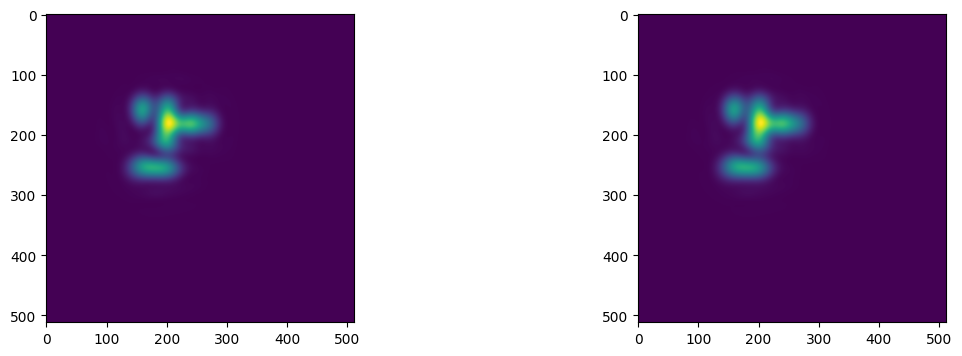

In [50]:
z = z_preds[:1].clone()
z[0,-2] = 1.
with torch.autocast(device_type=device.type):
    litho = model.sim.run_lithosim(litho_imgs[:1])
    aberr = model.sim.run_lithosim(litho_imgs[:1], zernike_coeffs=z)
    
fig = plt.figure(figsize=(14,4))
ax = plt.subplot(1,2,1)
# plt.imshow(dataset.intensity_tensor_to_image(litho[0]))
# # ax.set_title(f"Design {i+1}")
# ax = plt.subplot(1,2,2)
# plt.imshow(dataset.intensity_tensor_to_image(aberr[0]))
plt.imshow(tensor_to_image(litho[0]))
# ax.set_title(f"Design {i+1}")
ax = plt.subplot(1,2,2)
plt.imshow(tensor_to_image(aberr[0]))
# ax.set_title(f"Aberrated {i+1}")
print(z_preds[:1])

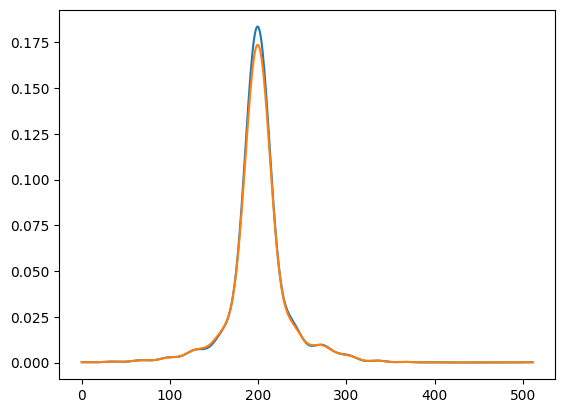

In [51]:
plt.plot(tensor_to_image(litho[0])[220])
plt.plot(tensor_to_image(aberr[0])[220])

Aberrations: Z=[ 2.307016  -1.2737027 -2.3869348 -2.9244282  1.8264817 -2.7533598]
Preds=[ 0.08915751  0.05682063 -0.00842904  0.07180708  3.1605933  -0.09620921]


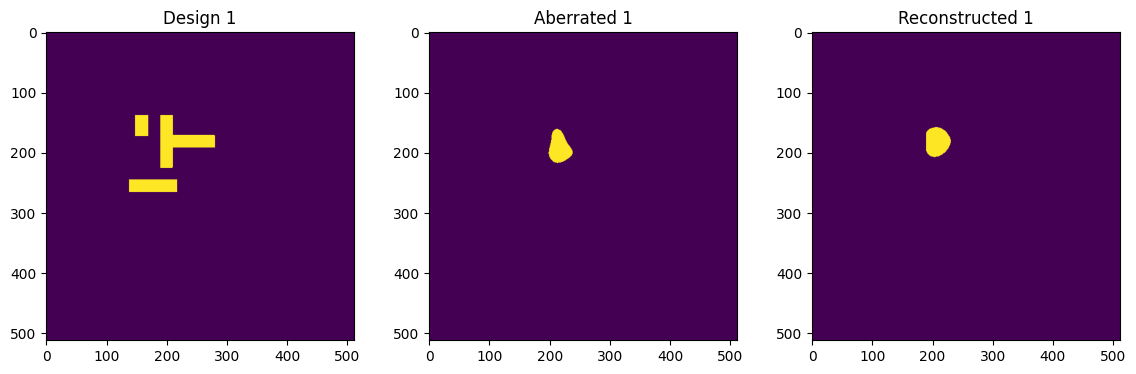

Aberrations: Z=[ 2.1283529  -2.5622928  -2.6778865   2.333437    0.38441885  1.101511  ]
Preds=[ 0.10503609  0.01277687 -0.03183378  0.08735173  3.1119378  -0.10508452]


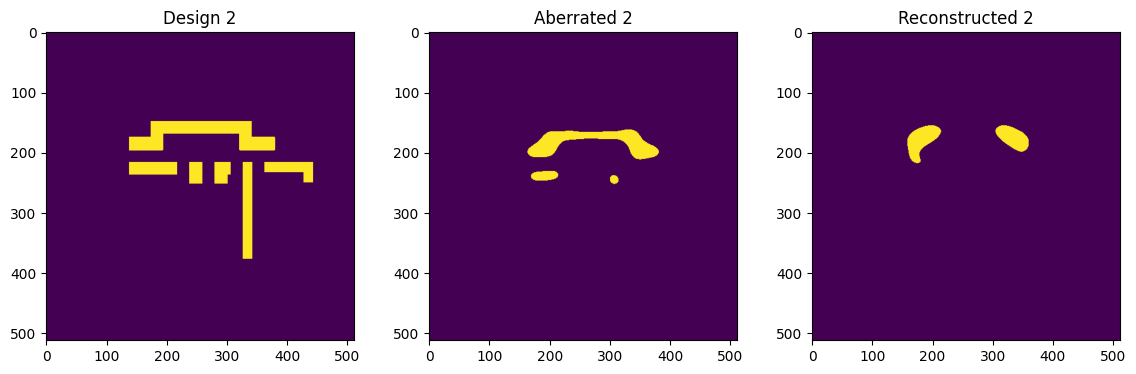

Aberrations: Z=[-0.24497867 -1.5907785   1.4203488   2.605155   -0.43212354 -1.0466838 ]
Preds=[ 0.10995267  0.00817502 -0.0331942   0.10328957  3.1435833  -0.08946066]


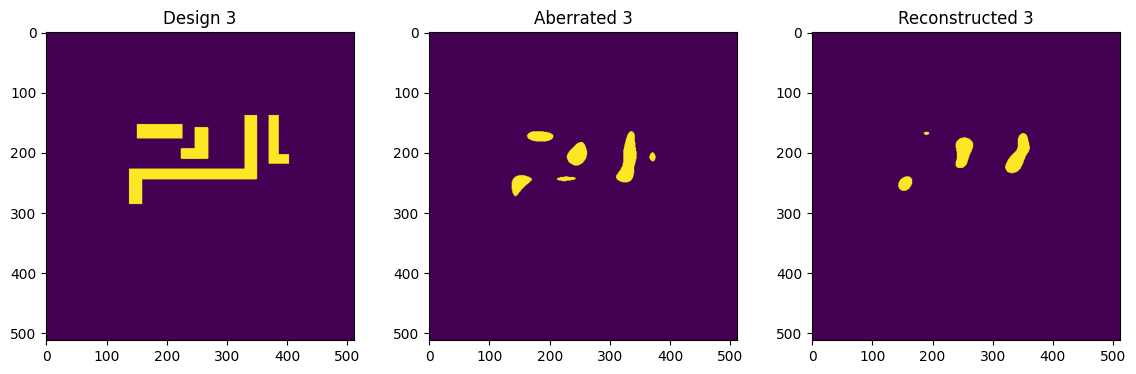

Aberrations: Z=[ 1.0551063  -0.7235445   0.22970116 -0.5403017   0.49556923 -2.9749067 ]
Preds=[ 0.10995226  0.00818635 -0.03321088  0.10329455  3.143543   -0.08945739]


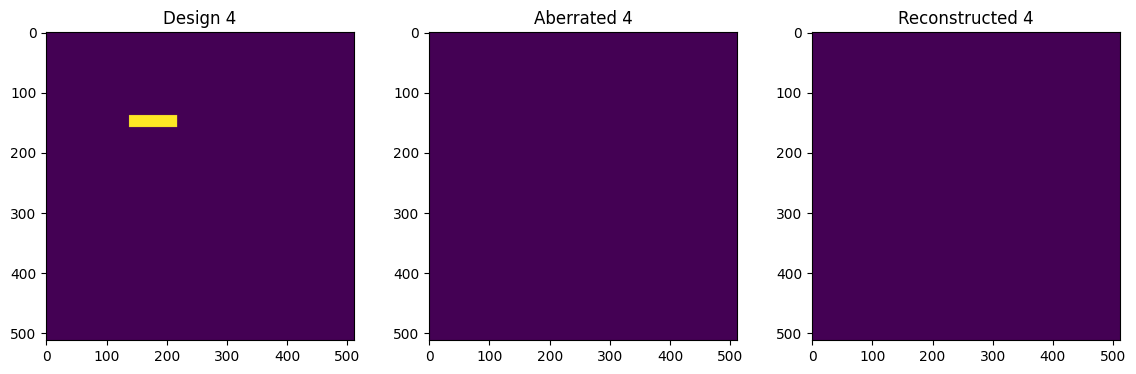

Aberrations: Z=[ 0.5481734  -0.76821506  1.6830486  -1.093625    0.14414406 -1.2018406 ]
Preds=[ 0.08979578  0.05674181 -0.00793313  0.06937451  3.1597652  -0.09508437]


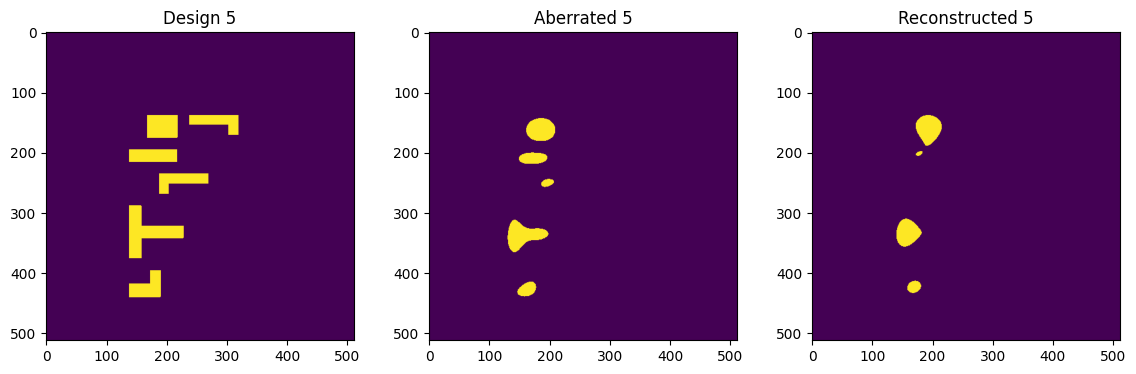

Aberrations: Z=[ 2.0143375   0.54291236  1.9251555   0.04137397  1.1461451  -1.6608696 ]
Preds=[ 0.10503598  0.01277987 -0.0318369   0.08734947  3.1119306  -0.10508394]


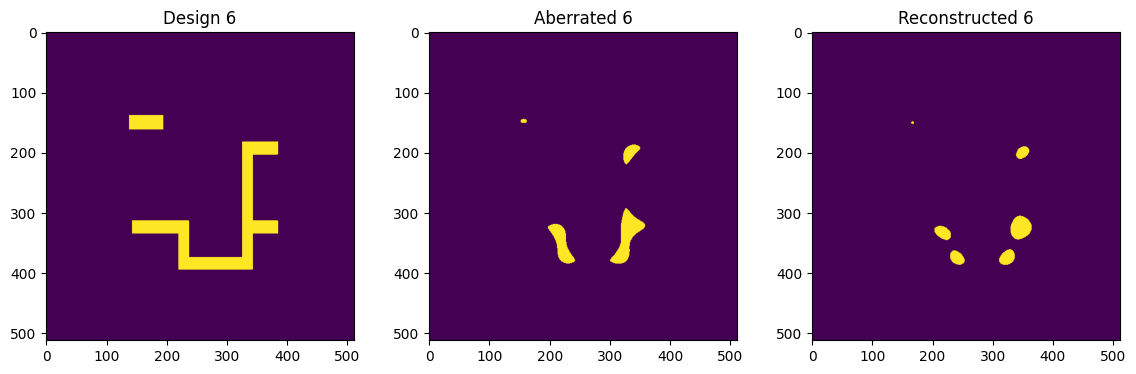

Aberrations: Z=[ 0.35743654  1.1764162   1.2895424   0.09028208 -0.7370882  -0.37609756]
Preds=[ 0.10503682  0.01278918 -0.03184831  0.08734954  3.111911   -0.10508069]


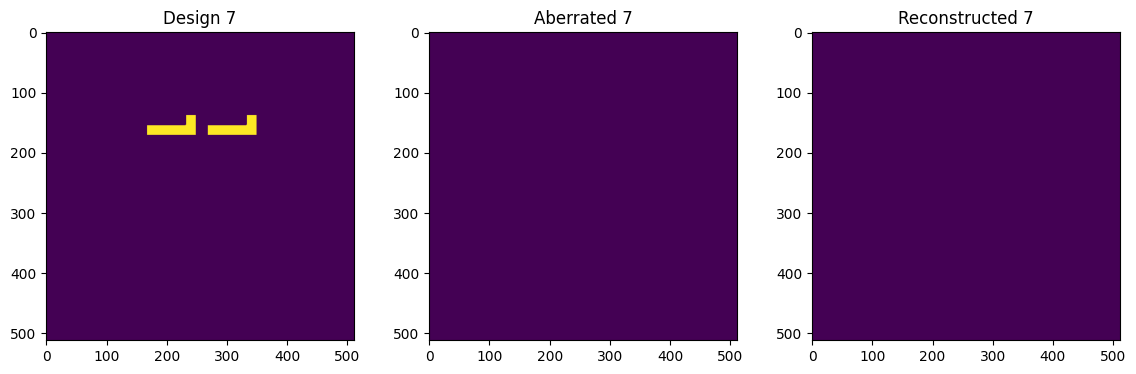

Aberrations: Z=[ 2.078456    0.17715776 -0.8187593   2.5718646   0.06518626 -2.2945538 ]
Preds=[ 0.09577059  0.05046875 -0.01008028  0.08787727  3.1942196  -0.07788906]


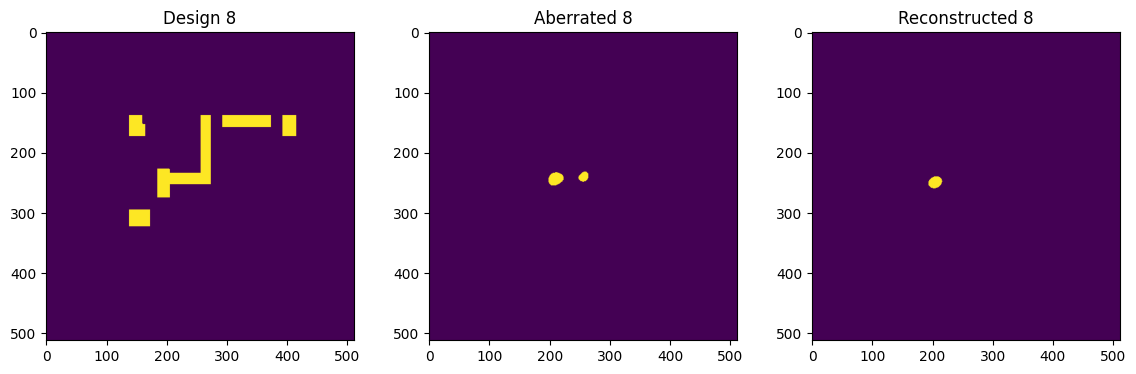

In [37]:
# i = 1
for i in range(imgs.shape[0]):

    fig = plt.figure(figsize=(14,4))
    ax = plt.subplot(1,3,1)
    plt.imshow(dataset.intensity_tensor_to_image(litho_imgs[i]))
    ax.set_title(f"Design {i+1}")
    ax = plt.subplot(1,3,2)
    plt.imshow(dataset.intensity_tensor_to_image(aberr_imgs[i]))
    ax.set_title(f"Aberrated {i+1}")
    ax = plt.subplot(1,3,3)
    plt.imshow(dataset.intensity_tensor_to_image(restored_imgs[i]))
    ax.set_title(f"Reconstructed {i+1}")
    print(f"Aberrations: Z={z_true[i].cpu().numpy()}\nPreds={z_preds[i].detach().cpu().numpy()}")
    plt.show()

In [38]:
# loss = model.loss_func(restored_imgs, litho_imgs) * 1e4
loss = model.loss_func(restored_imgs, litho_imgs, reduction='mean')
loss

tensor(0.0328, device='cuda:0', grad_fn=<MeanBackward0>)

In [30]:
# Получить финальный val_loss
final_val_loss = trainer.callback_metrics['val_loss'].item()
print('Final validation loss:', final_val_loss)

# Где лежит best checkpoint
print('Best model saved at:', checkpoint_callback.best_model_path)

# Сохранить вручную
torch.save(model.state_dict(), 'final_model.pt')

Final validation loss: 0.005996897350996733
Best model saved at: lightning_logs/convnext_tiny_1/version_13/checkpoints/best-model.ckpt
